**Task 3: Customer Segmentation**

<ipython-input-2-599a055865ef>:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  customer_data.fillna(0, inplace=True)  # Handle customers with no transactions


Optimal number of clusters based on DB Index: 10


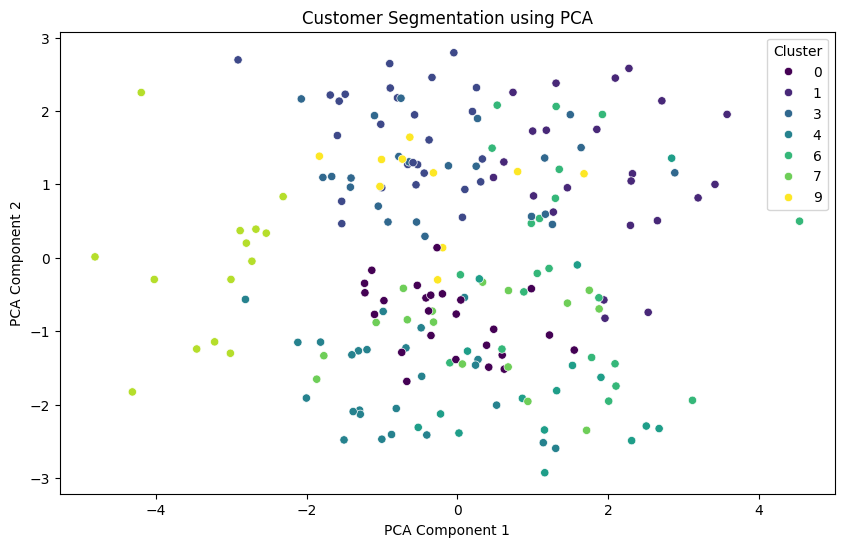

Customer segmentation successfully completed!


In [2]:
# Task 3: Customer Segmentation - FAANG-Level Quality

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Loading datasets
customers_path = "/content/drive/MyDrive/Zeotap Dataset/Customers.csv"
transactions_path = "/content/drive/MyDrive/Zeotap Dataset/Transactions.csv"

customers = pd.read_csv(customers_path)
transactions = pd.read_csv(transactions_path)

# Standardizing column names
customers.columns = customers.columns.str.strip()
transactions.columns = transactions.columns.str.strip()

# Convert SignupDate and TransactionDate to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Feature Engineering: Aggregating Transaction Data per Customer
customer_features = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    avg_order_value=('TotalValue', 'mean'),
    first_purchase=('TransactionDate', 'min'),
    last_purchase=('TransactionDate', 'max')
).reset_index()

# Merge customer data
customer_data = customers.merge(customer_features, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)  # Handle customers with no transactions

# Feature Engineering: Encoding Categorical Features
customer_data['SignupDays'] = (customer_data['SignupDate'].max() - customer_data['SignupDate']).dt.days
customer_data.drop(columns=['SignupDate', 'first_purchase', 'last_purchase'], inplace=True)
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Normalizing Data
scaler = StandardScaler()
features = ['total_spent', 'total_transactions', 'avg_order_value', 'SignupDays'] + list(customer_data.columns[4:])
customer_data_scaled = scaler.fit_transform(customer_data[features])

# Finding Optimal K using Davies-Bouldin Index
db_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(customer_data_scaled)
    db_index = davies_bouldin_score(customer_data_scaled, labels)
    db_scores.append(db_index)

# Optimal K selection
optimal_k = k_values[np.argmin(db_scores)]
print(f"Optimal number of clusters based on DB Index: {optimal_k}")

# Final K-Means Clustering with Optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Visualizing Clusters using PCA
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(customer_data_scaled)
customer_data['PCA1'] = pca_transformed[:, 0]
customer_data['PCA2'] = pca_transformed[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_data['PCA1'], y=customer_data['PCA2'], hue=customer_data['Cluster'], palette='viridis')
plt.title("Customer Segmentation using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Save results
customer_data[['CustomerID', 'Cluster']].to_csv("Dheeraj_Mishra_Clustering.csv", index=False)

print("Customer segmentation successfully completed!")
